In [56]:
import os

In [57]:
%pwd

'C:\\Users\\RICH-FILES\\Desktop\\ml\\AI-powered-Bank-Product-Recommender-Chatbot'

In [58]:
os.chdir("../.")

In [59]:
%pwd

'C:\\Users\\RICH-FILES\\Desktop\\ml'

In [60]:
project_dir = "C:/Users/RICH-FILES/Desktop/ml/AI-powered-Bank-Product-Recommender-Chatbot"
os.chdir(project_dir)

In [61]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class ModelEvaluationConfig:
    root_dir: Path
    test_data_path: Path
    model_path: Path
    metric_file_name: Path
    target_column: str
    params: dict[str, str]
    grid_search_model_path: Path
    train_data_path: Path
    encoded_target_label: Path
    
     
    

In [62]:
from BankProducts.constants import *
from BankProducts.utils.common  import read_yaml, create_directories
from BankProducts   import logger



In [63]:
class ConfigurationManager:
    def __init__(
        self,
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH,
        schema_filepath = SCHEMA_FILE_PATH):

        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        self.schema = read_yaml(schema_filepath)

        create_directories([self.config.artifacts_root])


    def get_model_evaluation_config(self) -> ModelEvaluationConfig:
        config = self.config.model_evaluation   
        params = self.params.random_forest
        schema =  self.schema.target_column

        create_directories([self.config.artifacts_root])

        model_evaluation_config = ModelEvaluationConfig(
            root_dir=Path(config.root_dir),
            test_data_path=Path(config.test_data_path),
            model_path=Path(config.model_path),
            metric_file_name=Path(config.metric_file_name),
            target_column=schema.name,
            params=params,
            grid_search_model_path= Path(config.grid_search_model_path),
            train_data_path=Path(config.train_data_path),
            encoded_target_label= Path(config.encoded_target_label)
            
            
           
            
        )

        return model_evaluation_config

In [64]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import pandas as pd
from BankProducts import logger
import seaborn as sns
from matplotlib import pyplot as plt
import tempfile
import mlflow
import joblib
from sklearn.preprocessing import LabelEncoder
from BankProducts.utils.common import save_json
from urllib.parse import urlparse
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='_distutils_hack')



In [65]:
from sklearn.model_selection import cross_val_score

class ModelEvaluation:
    def __init__(self, config):
        self.config = config
        
         
    
    def eval_metrics(self, actual, pred):
        accuracy = accuracy_score(actual, pred)
        precision = precision_score(actual, pred, average='weighted')
        recall = recall_score(actual, pred, average='weighted')
        f1 = f1_score(actual, pred, average='weighted')
        return accuracy, precision, recall, f1

    def log_confusion_matrix(self, actual, predicted, class_names):
        cm = confusion_matrix(actual, predicted)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                    xticklabels=class_names, yticklabels=class_names)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        temp_img_path = tempfile.NamedTemporaryFile(suffix=".png", delete=False).name
        plt.savefig(temp_img_path)
        plt.close()
        mlflow.log_artifact(temp_img_path, artifact_path="confusion_matrix")

    def log_classification_report(self, actual, predicted, class_names):
        report = classification_report(actual, predicted, target_names=class_names)
        temp_txt_path = tempfile.NamedTemporaryFile(suffix=".txt", delete=False).name
        with open(temp_txt_path, "w") as f:
            f.write(report)
        mlflow.log_artifact(temp_txt_path, artifact_path="bank_products_recommender")

    def log_into_mlflow(self):
        test_data = pd.read_csv(self.config.test_data_path)
        test_x = test_data.drop(columns=[self.config.target_column])
        test_y = test_data[self.config.target_column]
        

        # Encode the target variable
        le = joblib.load(self.config.encoded_target_label)
        test_y_encoded = le.transform(test_y)

        logger.info("Loading model from path: %s", self.config.model_path)
        pipeline = joblib.load(self.config.model_path)

        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
        mlflow.set_experiment("Product Recommender")

        if mlflow.active_run():
            mlflow.end_run()

        with mlflow.start_run():
            predicted = pipeline.predict(test_x)

            accuracy, precision, recall, f1 = self.eval_metrics(test_y_encoded, predicted)
            
             # evaluate the model
            rf_report = classification_report(test_y_encoded, predicted)
            rf_cm = confusion_matrix(test_y_encoded, predicted)   
            rf_accuracy = accuracy_score(test_y_encoded, predicted)   
            
            #create Confusion Matrix Display
            cm_display = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=le.classes_)
                    
            plt.title("Classifier Matrix")
            cm_display.plot()
            plt.xticks(rotation=180)
            
            

            logger.info(f"Classification Report:\n{rf_report}")
            logger.info(f"Confusion Matrix:\n{rf_cm}") 
            logger.info(f"sAccuracy: {rf_accuracy}")
            

            scores = {
                "model_name": "logistic_classifier",
                "accuracy": accuracy,
                "precision": precision,
                "recall": recall,
                "f1_score": f1
            }
            
            # Ensure directory exists
            Path(self.config.metric_file_name).parent.mkdir(parents=True, exist_ok=True)

            save_json(Path(self.config.metric_file_name), data=scores)
            
            logger.info("Metrics saved to: %s", self.config.metric_file_name)
            
            logger.info("Logging accuracy")
            mlflow.log_metric("accuracy", accuracy)

            logger.info("Logging precision")
            mlflow.log_metric("precision", precision)

            logger.info("Logging recall")
            mlflow.log_metric("recall", recall)

            logger.info("Logging f1_score")
            mlflow.log_metric("f1_score", f1)

            logger.info("Setting class_names")
            class_names = le.classes_

            logger.info("Logging confusion matrix")
            self.log_confusion_matrix(test_y_encoded, predicted, class_names)

            logger.info("Logging classification report")
            self.log_classification_report(test_y_encoded, predicted, class_names)
            
            
            logger.info("Tracking URI scheme: %s", tracking_url_type_store)
            logger.info("Tracking URI: %s", mlflow.get_tracking_uri())


            #if tracking_url_type_store != "file":
                #mlflow.sklearn.log_model(pipeline, "pipeline", registered_model_name="product recommender")
            #else:
                #mlflow.sklearn.log_model(pipeline, "pipeline")
              
            logger.info("mlflow model logged successfully.")
            
            
            
            

    # perform a Grid Search to find the best model
    
    def perform_grid_search(self):
        from sklearn.model_selection import GridSearchCV
        from sklearn.pipeline import Pipeline
        from sklearn.linear_model import LogisticRegression
        from sklearn.preprocessing import StandardScaler, OneHotEncoder
        from sklearn.compose import ColumnTransformer

        # Load **training** data
        train_data = pd.read_csv(self.config.train_data_path)  # <-- FIXED from test_data_path
        X_train = train_data.drop(columns=[self.config.target_column])
        y_train = train_data[self.config.target_column]

        # Identify features
        numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
        categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

        # Preprocessing
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numeric_features),
                ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
            ])

        # Pipeline
        model = LogisticRegression(random_state=42, max_iter=1000)  # Ensure convergence
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('log_regression', model)])

        #  Define hyperparameter grid (note the prefix 'log_regression__' for pipeline)
        param_grid = {
            'log_regression__C': [0.01, 0.1, 1, 10, 100],
            'log_regression__penalty': ['l2'],
            'log_regression__solver': ['lbfgs', 'liblinear']
        }

        # Grid Search
        grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)
        grid_search.fit(X_train, y_train)

        logger.info("Best parameters found: %s", grid_search.best_params_)

        # Save the best model
        joblib.dump(grid_search.best_estimator_, self.config.grid_search_model_path)
        logger.info("Best model saved to: %s", self.config.grid_search_model_path)

        # Feature importance not supported for LogisticRegression directly here
        importance_df = pd.DataFrame()  # Not applicable unless using coefficients manually

        return importance_df


[2025-06-13 23:32:21,509: INFO: common: yaml file: config\config.yaml loaded successfully]
[2025-06-13 23:32:21,517: INFO: common: yaml file: params.yaml loaded successfully]
[2025-06-13 23:32:21,557: INFO: common: yaml file: schema.yaml loaded successfully]
[2025-06-13 23:32:21,560: INFO: common: created directory at: artifacts]
[2025-06-13 23:32:21,561: INFO: common: created directory at: artifacts]
[2025-06-13 23:32:22,074: INFO: 1625736662: Loading model from path: artifacts\model_training\random.joblib]
[2025-06-13 23:32:23,081: INFO: 1625736662: Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       800
           1       0.99      0.98      0.98      1071
           2       0.97      1.00      0.99       552
           3       1.00      0.96      0.98      1530
           4       0.89      1.00      0.94       270
           5       0.95      1.00      0.98       544
           6       1.00      0.99      0

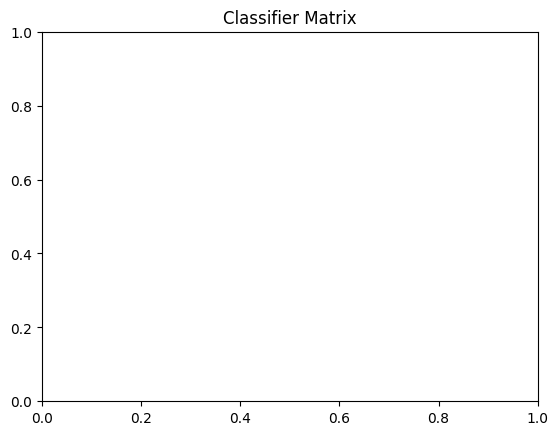

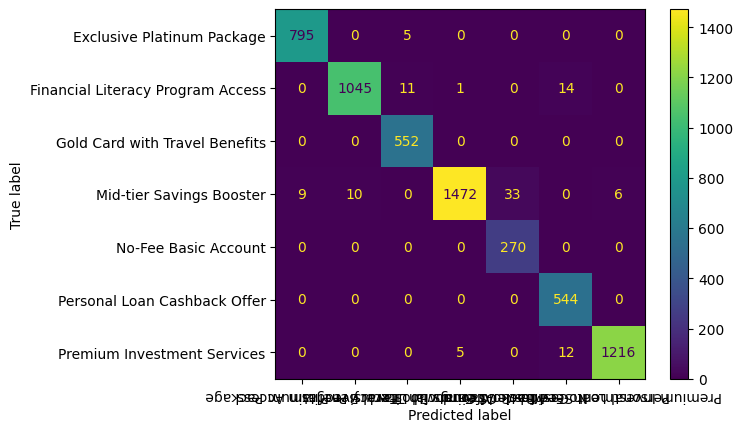

In [66]:
try:
    config = ConfigurationManager()
    model_evaluation_config = config.get_model_evaluation_config()
    eval = ModelEvaluation(config=model_evaluation_config)
    eval.log_into_mlflow()
    #eval.validate_model()
    eval.perform_grid_search()  
    
    

except Exception as e:
    print(f"An error occurred: {e}")
    
    
    